# Is It Real?!
Let's make some extra plots to explore things the referee wisely points out.

## 1: The period gradient, are you triple sure?

A very fair question! Let's be double/triple sure!!

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from scipy.optimize import curve_fit

from scipy.stats import binned_statistic_2d

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

In [3]:
Gfile = '../data/kepler_dr2_1arcsec.fits' # from http://gaia-kepler.fun, thanks to M. Bedell
data = Table.read(Gfile, format='fits')
gaia = data.to_pandas()
print(gaia.shape)

rot_file = '../data/Table_Periodic.txt'
rot = pd.read_csv(rot_file)
df = pd.merge(rot, gaia, right_on='kepid', left_on='KID')
print(df.shape)

ok = np.where(np.isfinite(df[u'parallax']) & # this is basically the same as the TGAS file...
              (df[u'parallax_error'] < 0.1) &
              (df[u'r_modality_flag'] == 1) & 
              (df[u'r_result_flag'] == 1) &
              np.isfinite(df[u'bp_rp']) & 
              (df[u'phot_bp_mean_flux_error']/df[u'phot_bp_mean_flux'] < 0.01) & 
              (df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01) & 
              (df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01))[0]
print(ok.shape)

(195830, 101)
(33538, 112)
(30305,)


We can re-make the key figure very simply after applying sensible selection cuts (`ok = ` above)

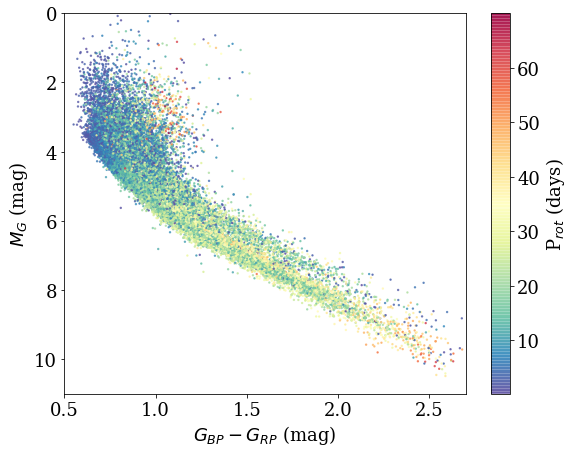

In [4]:
# plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral_r')

fig, ax1 = plt.subplots(figsize=(9,7))

plt.scatter(df[u'bp_rp'].values[ok], 
            df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
            c=(df[u'Prot'].values[ok]), alpha=0.7, s=2, cmap=cm)

plt.ylim(11,0)
plt.xlim(.5,2.7)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')

the only other photometric colors we have available for every star in our sample right now is the 2MASS *JHKs* bands, so lets make some CMDs to see if we can see the period gradient near the K dwarfs (where it's most notable, M_G~7)

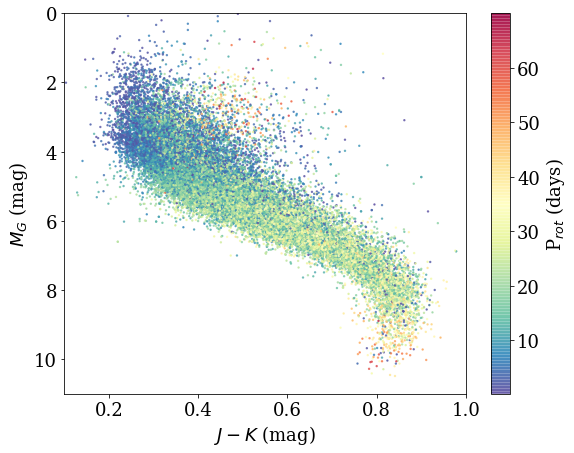

In [9]:

cm = plt.cm.get_cmap('Spectral_r')

fig, ax1 = plt.subplots(figsize=(9,7))

plt.scatter(df['jmag'].values[ok] - df['kmag'].values[ok], 
            df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
            c=(df[u'Prot'].values[ok]), alpha=0.7, s=2, cmap=cm)


plt.ylim(11,0)
plt.xlim(0.1,1)
plt.xlabel('$J-K$ (mag)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')

You can barely **maybe** see it here in the full 2MASS CMD, zoomed into near the K dwarfs, but *J-K* just isn't precise enough to pull the colors apart.

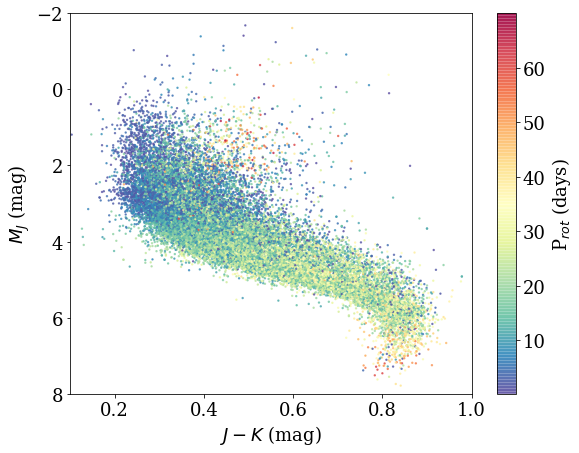

In [24]:
cm = plt.cm.get_cmap('Spectral_r')

fig, ax1 = plt.subplots(figsize=(9,7))

plt.scatter(df['jmag'].values[ok] - df['kmag'].values[ok], 
            df['jmag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
            c=(df[u'Prot'].values[ok]), alpha=0.7, s=2, cmap=cm)


plt.ylim(8,-2)
plt.xlim(0.1,1)
plt.xlabel('$J-K$ (mag)')
plt.ylabel('$M_J$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')



**BUT** we have one other option: Teff, compiled by the KIC based on multi-color photometry (not just 2MASS). This should be useful (independant, many colors, some accounting for extinction, etc)... and indeed you can start to see period gradient pop up again!

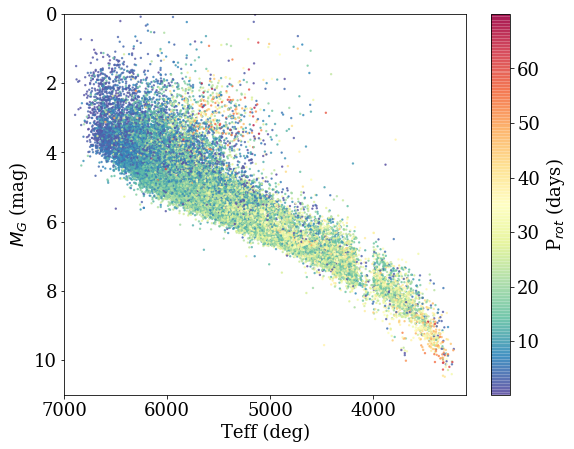

In [14]:
cm = plt.cm.get_cmap('Spectral_r')

fig, ax1 = plt.subplots(figsize=(9,7))

plt.scatter(df['teff'].values[ok], 
            df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
            c=(df[u'Prot'].values[ok]), alpha=0.7, s=2, cmap=cm)


plt.ylim(11,0)
plt.xlim(7000,3100)
plt.xlabel('Teff (deg)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')

here we've twisted the color-scheme, and zoomed in to highlight the feature again between the main and binary sequences near the K dwarfs:

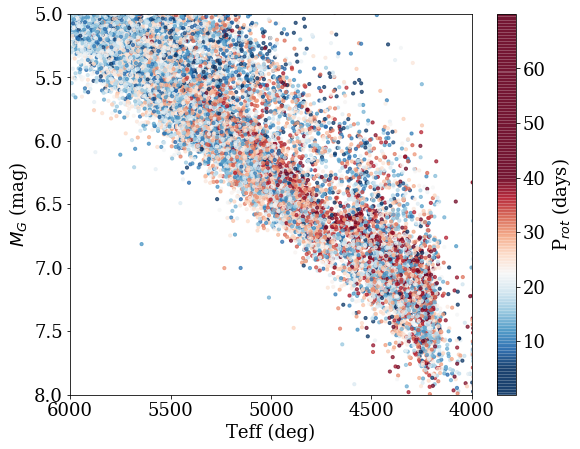

In [37]:
cm = plt.cm.get_cmap('RdBu_r')

fig, ax1 = plt.subplots(figsize=(9,7))

plt.scatter(df['teff'].values[ok], 
            df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
            c=(df[u'Prot'].values[ok]), alpha=0.7, s=10, cmap=cm)

plt.ylim(8,5)
plt.xlim(6000,4000)
plt.xlabel('Teff (deg)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')
cb.set_clim(5,40)

## 2: maybe split the sample, A/B test?

This is a thought I had as another way to sanity check...

In [53]:
AA = ok[0:int(len(ok)/2)]
BB = ok[int(len(ok)/2):]

print(len(ok), len(AA)+len(BB))

30305 30305


Text(0.5,1,'AA')

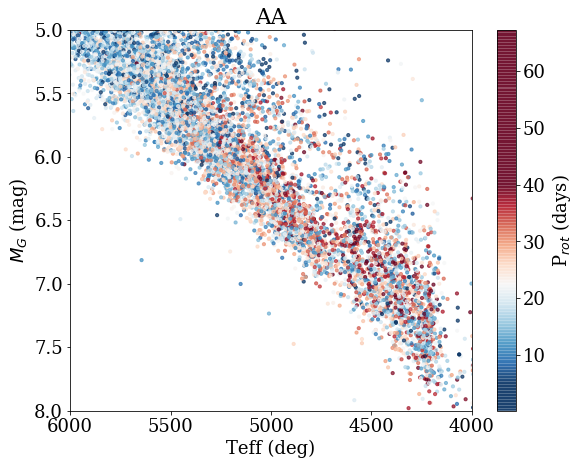

In [54]:
cm = plt.cm.get_cmap('RdBu_r')

fig, ax1 = plt.subplots(figsize=(9,7))

plt.scatter(df['teff'].values[AA], 
            df[u'phot_g_mean_mag'].values[AA] - 5. * np.log10(df[u'r_est'].values[AA])  + 5, 
            c=(df[u'Prot'].values[AA]), alpha=0.7, s=10, cmap=cm)

plt.ylim(8,5)
plt.xlim(6000,4000)
plt.xlabel('Teff (deg)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')
cb.set_clim(5,40)
plt.title('A-Half')

Text(0.5,1,'B-Half')

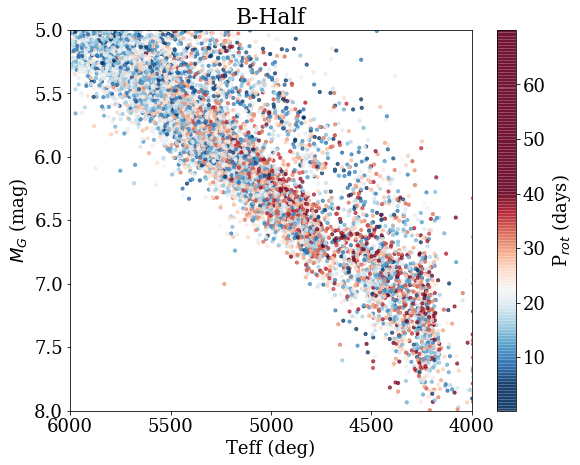

In [56]:
cm = plt.cm.get_cmap('RdBu_r')

fig, ax1 = plt.subplots(figsize=(9,7))

plt.scatter(df['teff'].values[BB], 
            df[u'phot_g_mean_mag'].values[BB] - 5. * np.log10(df[u'r_est'].values[BB])  + 5, 
            c=(df[u'Prot'].values[BB]), alpha=0.7, s=10, cmap=cm)

plt.ylim(8,5)
plt.xlim(6000,4000)
plt.xlabel('Teff (deg)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')
cb.set_clim(5,40)
plt.title('B-Half')